# Entities

Here we introduce our entities object. It handles the researchers (or groups) data and all its queries (RCA and predictions).

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.patheffects as path_effects

import sys
sys.path.append("../")
from MapSci.papers import papers
from MapSci.research_space import research_space
from MapSci.entities import entities
import MapSci.agg as agg

As in [the previous notebook](https://github.com/franciscogaluppo/science-of-science/blob/master/examples/2\)%20Research%20Space.ipynb), we will first load our papers object using the 'lattes_categories' key. We will also initialize our research space object with the same key, passing our papers as a parameter, and computing the spaces for our timeframe of interest.

In [2]:
pp = papers("lattes_categories")
maps = research_space("lattes_categories", pp)
maps.compute(1999, 2013)

frequentist(1999, 2013, 0.1)
embedding(1999, 2013, 0.1, 200)


To create an entities object, we need a presence matrix and the indices used in the models to represent the research fields.

In [3]:
presence = pp.presence(1999, 2013)
indices = maps.phi["frequentist(1999, 2013, 0.1)"][1]
scientists = entities(presence, indices)

We can also aggregate our researchers by institutions and by states.

In [4]:
inst, st = agg.get_insts(scientists.set, "../dataset/lattes/pesquisadores.csv", sep=";sep;")
x = agg.aggregate(presence[1], inst)
presence_inst = pp.presence(1999, 2013, x=x)
institutions = entities(presence_inst, indices)

Let's choose some institutions of interest. The first two are important federal universities in Brazil, both in the state of Minas Gerais. The first one is one of the largest universities in the whole country, while the second one is highly specialized in agriculture. Then we have two public institutions of research: INPE for space research and FIOCRUZ for public health.

In [5]:
insts = [
    "universidade federal de minas gerais",
    "universidade federal de lavras",
    "instituto nacional de pesquisas espaciais",
    "fundacao oswaldo cruz"
]

Let's see in which fields INPE has RCA greater than one:

In [6]:
for i in institutions.rca:
    if i[0] != 'instituto nacional de pesquisas espaciais':
        continue
    
    if institutions.rca[i] > 1.0:
        print("{: >60} {: >20}".format(i[1], str(institutions.rca[i])))

Next we will first load a dataframe that maps every field to the intermediate ("Classification") and macro ("Subject area") areas. Then let's see some results!

In [7]:
areas = pd.read_pickle("../dataset/SJR/areas.pkl")

dict_macro = areas[["Classification", "Subject area"]].set_index("Classification").to_dict()["Subject area"]
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
unique = sorted(areas["Classification"].unique().tolist())
unique = sorted(unique, key=lambda x: dict_macro[x])
size = Counter(areas["Classification"].tolist())
macro = dict()

for sf, rca in institutions.rca.items():
    if rca > 1:
        if (sf[0], dict_area[sf[1]]) in macro:
            macro[(sf[0], dict_area[sf[1]])] += 1 / size[dict_area[sf[1]]]
        else:
            macro[(sf[0], dict_area[sf[1]])] = 1 / size[dict_area[sf[1]]] 

The lengthy cell below is great to visualize where these selected institutions shine the most. We are looking for all 27 intermediate areas and calculating the fraction of the smaller, specific fields that have RCA greater than one, for each institution.

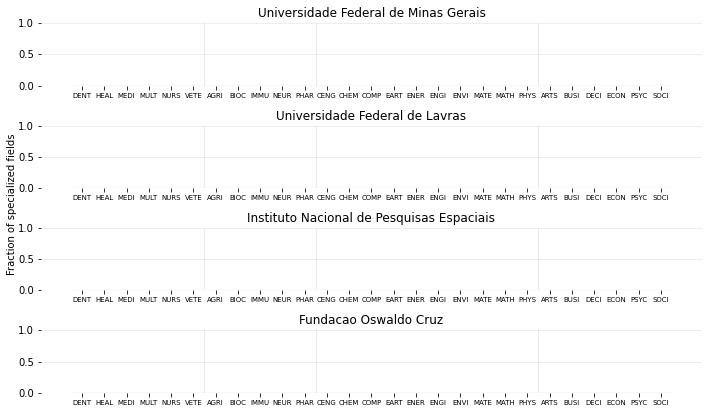

In [8]:
plt.rcParams["figure.figsize"] = (9.8,8.5)
cm = cmx.get_cmap('viridis', 27)
color = cm([0]*6 + [1/3]*5 +[2/3]*10 + [1]*6).tolist()
fig = plt.figure()
xs = [unique[x][:4].upper() for x in range(27)]
xs[11] = 'CENG'

for i in range(len(insts)):
    uni = insts[i]
    areas_list = list()
    for a in unique:
        if (uni, a) in macro:
            areas_list.append(macro[(uni, a)])
        else:
            areas_list.append(0)

    title = []
    for s in uni.split():
        if s not in ['da', 'de']:
            title.append(s.title())
        else:
            title.append(s)
    title = " ".join(title)
            
    ax = fig.add_subplot(6,1,i+1)
    ax.yaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax.yaxis.grid(zorder=0)
    bars = ax.bar(xs, areas_list, color=color, width=1, zorder=3, edgecolor='grey', lw=0.1)
    
    patterns = ["x" if i == 3 else "" for i in range(27)]
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)

    plt.xticks( size=7)
    plt.title(title)
    plt.ylabel("")
    plt.xlabel("")
    plt.box(False)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,1))
    
    ax.plot([5.5,5.5], [0,1], color='#999999', linestyle='-', alpha=0.2, zorder=0,lw=1)
    ax.plot([10.5,10.5], [0,1], color='#999999', linestyle='-', alpha=0.2, zorder=0,lw=1)
    ax.plot([20.5,20.5], [0,1], color='#999999', linestyle='-', alpha=0.2, zorder=0,lw=1)
    
fig.text(0.00, 0.66, 'Fraction of specialized fields', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

Another great idea is to check the probability distribution of the number of active (RCA > 0) and specialized (RCA > 1) fields. We see that it is heavy-tailed, but remember that it has a "ceiling". The maximum number of fields is finite.

IndexError: list index out of range

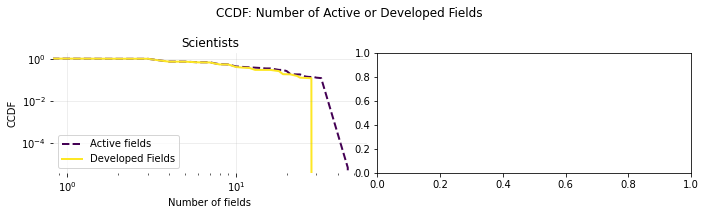

In [10]:
plt.rcParams["figure.figsize"] = (9.8,3)
col = plt.cm.viridis([0,1.1])
fig = plt.figure()
fig.suptitle("CCDF: Number of Active or Developed Fields")
t = ["Scientists", "Institutions"]
Us = [[[len(U[x]) for x in U] for U in f._U] for f in [scientists, institutions]]

for f in range(len(Us)):
    ax = fig.add_subplot(1,2,f+1)
    for i in range(len(Us[f])):
        dis = Us[f][i]
        d = [0]+sorted([dis[k] for k in dis])
        if f == 0 and i == 0:
            d = [x for x in d if x < 51]
        X, F = np.unique(d, return_index=True)
        ccdf = 1-F/F.max()
        if i == 0:
            plt.plot(X,ccdf,lw=2,zorder=1,color=col[i], linestyle='--')
        else:
            plt.plot(X,ccdf,lw=2,zorder=1,color=col[i])

    plt.title(t[f])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('CCDF')
    plt.xlabel('Number of fields')
    if f%2 == 0:
        plt.legend(['Active fields', 'Developed Fields'])
        plt.ylabel('CCDF')
    else:
        plt.ylabel('')
    plt.box(False)
    plt.tight_layout()

    ax.yaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax.yaxis.grid(zorder=0)
    ax.xaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax.xaxis.grid(zorder=0)

fig.subplots_adjust(top=0.8)
plt.savefig("nfields.pdf",bbox_inches='tight')